<a href="https://colab.research.google.com/github/GKGUK/undeepvo/blob/master/undeepvo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load git

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    # Change MisterMap to your github account name and make fun
    !pip install grpcio
    !pip install --upgrade -q git+https://github.com/MisterMap/undeepvo.git

In [ ]:
from google.colab import output

def notify_start():
    output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/' +\
        'pronunciation/2019-10-21/audio/tr/train_en_us_1.mp3").play()')
    output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/' +\
        'pronunciation/2019-10-21/audio/st/start_en_us_1.mp3").play()')

def notify_end():
    output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/' +\
        'pronunciation/2019-10-21/audio/tr/train_en_us_1.mp3").play()')
    output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/' +\
        'pronunciation/2019-10-21/audio/do/done_en_us_1.mp3").play()')

# Run full pipeline

In [ ]:
DO_TRAIN = False
LOAD_MODEL = True

## Load dataset

In [ ]:
import pykitti.odometry

from undeepvo.data import Downloader
from undeepvo.models import UnDeepVO
from undeepvo.problems import UnsupervisedDatasetManager, UnsupervisedDepthProblem
from undeepvo.utils import OptimizerManager, TrainingProcessHandler
from undeepvo.criterion import UnsupervisedCriterion

In [ ]:
import random
import numpy as np
import torch

seed = 1


torch.backends.cudnn.deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MAIN_DIR = '/content/drive/My Drive/dataset'
lengths = (300, 20, 20)
image_step = 1
dataset = pykitti.odometry(MAIN_DIR, '08', frames=range(0, 340, 1))
dataset_manager = UnsupervisedDatasetManager(dataset, lengths=lengths)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Dataset] - train size = 300
[Dataset] - validation size = 20
[Dataset] - test size = 20


## Run pipeline

In [ ]:
if IN_COLAB:
    %load_ext tensorboard
    %tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [ ]:
seed = 1


torch.backends.cudnn.deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


max_depth = 100
min_depth = 1
last_sigmoid = True

model = UnDeepVO(max_depth, min_depth, resnet=True).cuda()

In [ ]:
lr = 1e-4
lambda_position = 0.01
lambda_rotation = 0.1
lambda_s = 0.85
lambda_disparity = 0.
batch_size = 4
weight_decay = 0
betta2 = 0.99
betta1 = 0.9
lambda_registration = 1e-6
use_truth_poses=False
mlflow_parameters = {"lr": lr,
                     "lambda_position": lambda_position,
                     "lambda_rotation": lambda_rotation,
                     "lambda_s": lambda_s,
                     "lambda_disparity": lambda_disparity,
                     "lambda_registration": lambda_registration,
                     "batch_size": batch_size,
                     "weight_decay": weight_decay,
                     "betta2": betta2,
                     "betta1": betta1,
                     "image_step": image_step,
                     "max_depth": max_depth,
                     "min_depth": min_depth,
                     "use_truth_poses": use_truth_poses}
criterion = UnsupervisedCriterion(dataset_manager.get_cameras_calibration("cuda:0"),
                                  lambda_position, lambda_rotation, lambda_s,
                                  lambda_disparity, lambda_registration)
handler = TrainingProcessHandler(mlflow_tags={"name": "MishaNotebook"},
                                 mlflow_parameters=mlflow_parameters)
optimizer_manger = OptimizerManager(lr=lr, betas=(betta1, betta2), weight_decay=weight_decay)
problem = UnsupervisedDepthProblem(model, criterion, optimizer_manger,
                                   dataset_manager, handler,
                                   batch_size=batch_size, name="undeepvo", use_truth_poses=use_truth_poses)

In [ ]:
if DO_TRAIN:
    notify_start()
    problem.train(30)
    notify_end()

In [ ]:
if LOAD_MODEL:
    model.load_state_dict(torch.load("checkpoint.pth"))

## Depth evaluation

([], <a list of 0 Text major ticklabel objects>)

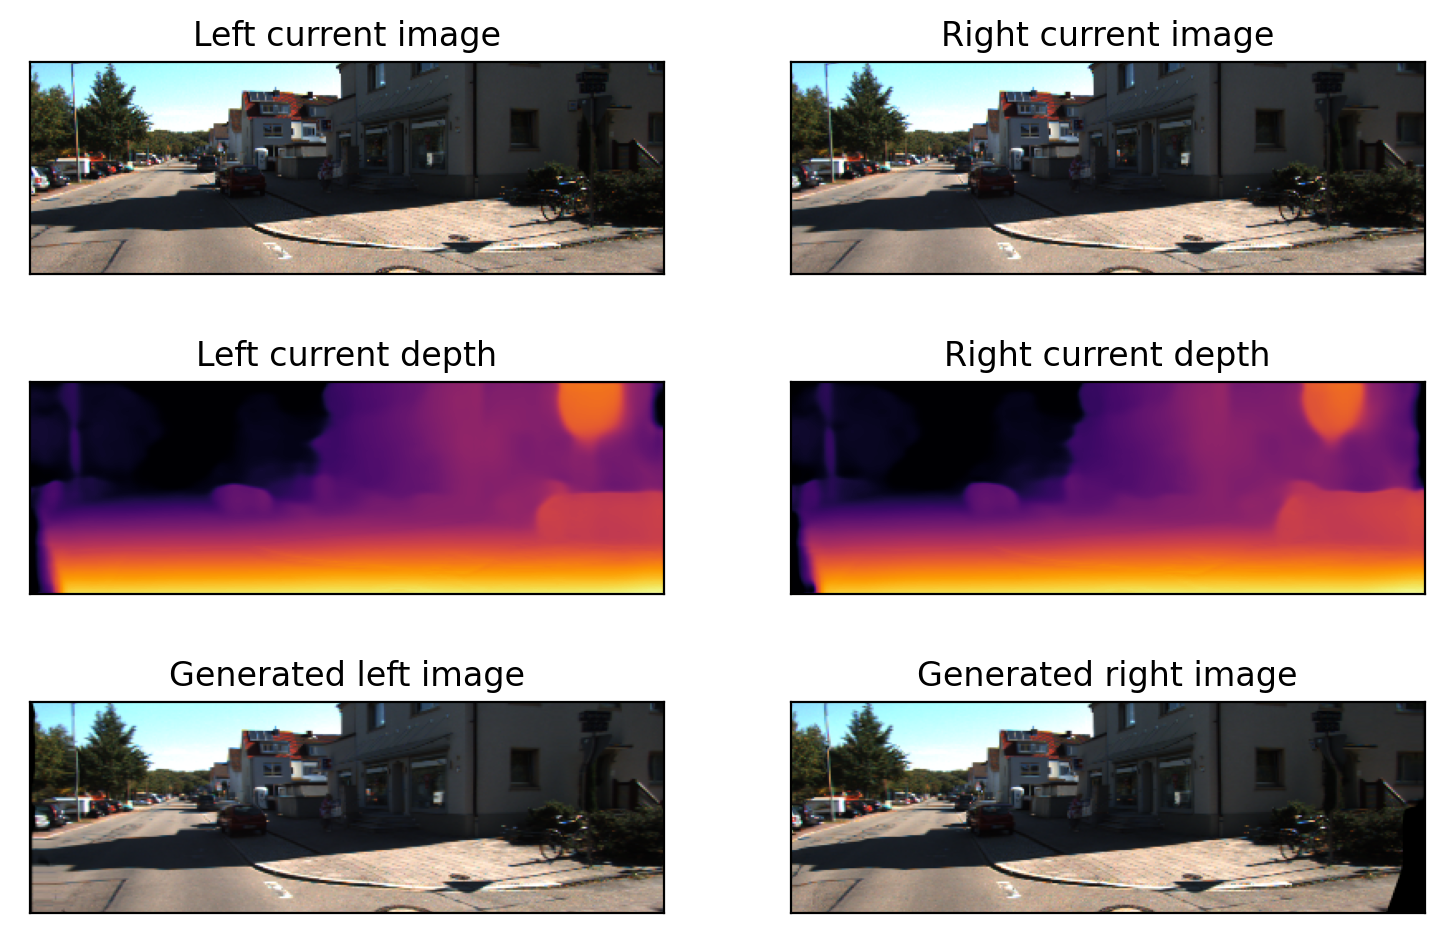

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import kornia
model.eval()
device = "cuda:0"
data_point = dataset_manager.get_validation_dataset(with_normalize=True)[0]
with torch.no_grad():
    left_current_depth = model.depth(data_point["left_current_image"][None].to(device))
    right_current_depth = model.depth(data_point["right_current_image"][None].to(device))
data_point = dataset_manager.get_validation_dataset(with_normalize=False)[0]
left_current_image = data_point["left_current_image"][None].to(device)
right_current_image = data_point["right_current_image"][None].to(device)
cameras_calibration = dataset_manager.get_cameras_calibration(device=device)
with torch.no_grad():
    generated_left_image = kornia.warp_frame_depth(right_current_image,
                                                    left_current_depth,
                                                    cameras_calibration.transform_from_left_to_right,
                                                    cameras_calibration.left_camera_matrix)
    generated_right_image = kornia.warp_frame_depth(left_current_image,
                                                    right_current_depth,
                                                    torch.inverse(
                                                        cameras_calibration.transform_from_left_to_right),
                                                    cameras_calibration.left_camera_matrix)

figure = plt.figure(dpi=200, figsize=(9, 6))

plt.subplot(3, 2, 1)
image = left_current_image[0].cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(np.clip(image, 0, 1))
plt.title("Left current image")
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 2)
image = right_current_image[0].cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(np.clip(image, 0, 1))
plt.title("Right current image")
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 3)
depth_image = left_current_depth[0].detach().cpu().permute(1, 2, 0).numpy()[:, :, 0]
plt.imshow(np.clip(1.0 / depth_image, 0, 100) / 100, cmap="inferno")
plt.title("Left current depth")
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 4)
depth_image = right_current_depth[0].detach().cpu().permute(1, 2, 0).numpy()[:, :, 0]
plt.imshow(np.clip(1.0 / depth_image, 0, 100) / 100, cmap="inferno")
plt.title("Right current depth")
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 5)
image = generated_left_image[0].cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(np.clip(image, 0, 1))
plt.title("Generated left image")
plt.xticks([])
plt.yticks([])

plt.subplot(3, 2, 6)
image = generated_right_image[0].cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(np.clip(image, 0, 1))
plt.title("Generated right image")
plt.xticks([])
plt.yticks([]);

# Pose evaluation

In [ ]:
dataset_index = 43
data_point = dataset_manager.get_validation_dataset(with_normalize=True)[dataset_index]
print(f"for {dataset_index} data point: ")
print(f"truth delta position = {data_point['delta_position']}")
print(f"truth delta angle = {data_point['delta_angle']}")
current_image = data_point["right_current_image"]
next_image = data_point["right_next_image"]
result = model.pose(current_image[None].to("cuda:0"), next_image[None].to("cuda:0"))
print(f"predicted delta position = {result[1].data}")
print(f"predicted delta angle = {result[0].data}")

for 43 data point: 
truth delta position = tensor([ 0.0170, -0.0232,  1.1739])
truth delta angle = tensor([-0.0001,  0.0003,  0.0004])
predicted delta position = tensor([[ 0.0097, -0.0132,  1.1014]], device='cuda:0')
predicted delta angle = tensor([[ 0.0008, -0.0005,  0.0006]], device='cuda:0')


# Evaluate sequence

In [ ]:
image_count = 4070
lengths = (0, image_count, 0)
image_step = 1
dataset = pykitti.odometry(MAIN_DIR, '08', frames=range(0, image_count, 1))
dataset_manager = UnsupervisedDatasetManager(dataset, lengths=lengths)

[Dataset] - train size = 0
[Dataset] - validation size = 4070
[Dataset] - test size = 0


In [ ]:
from undeepvo.utils.math import generate_transformation
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [ ]:

predicted_poses = [np.eye(4, dtype=np.float32)]
raw_dataset = dataset_manager.get_validation_dataset(with_normalize=True).dataset
data_loader = DataLoader(raw_dataset, batch_size=8, shuffle=False, num_workers=4)
for batch in tqdm(data_loader):
    current_image = batch["right_current_image"]
    next_image = batch["right_next_image"]
    result = model.pose(current_image.to("cuda:0"), next_image.to("cuda:0"))
    transformations = generate_transformation(result[1], result[0]).cpu().detach().numpy()
    for predicted_transformation in transformations:
        next_pose = predicted_poses[-1].dot(predicted_transformation)
        predicted_poses.append(next_pose)
predicted_poses = predicted_poses[:-1]

Text(0, 0.5, 'y, m')

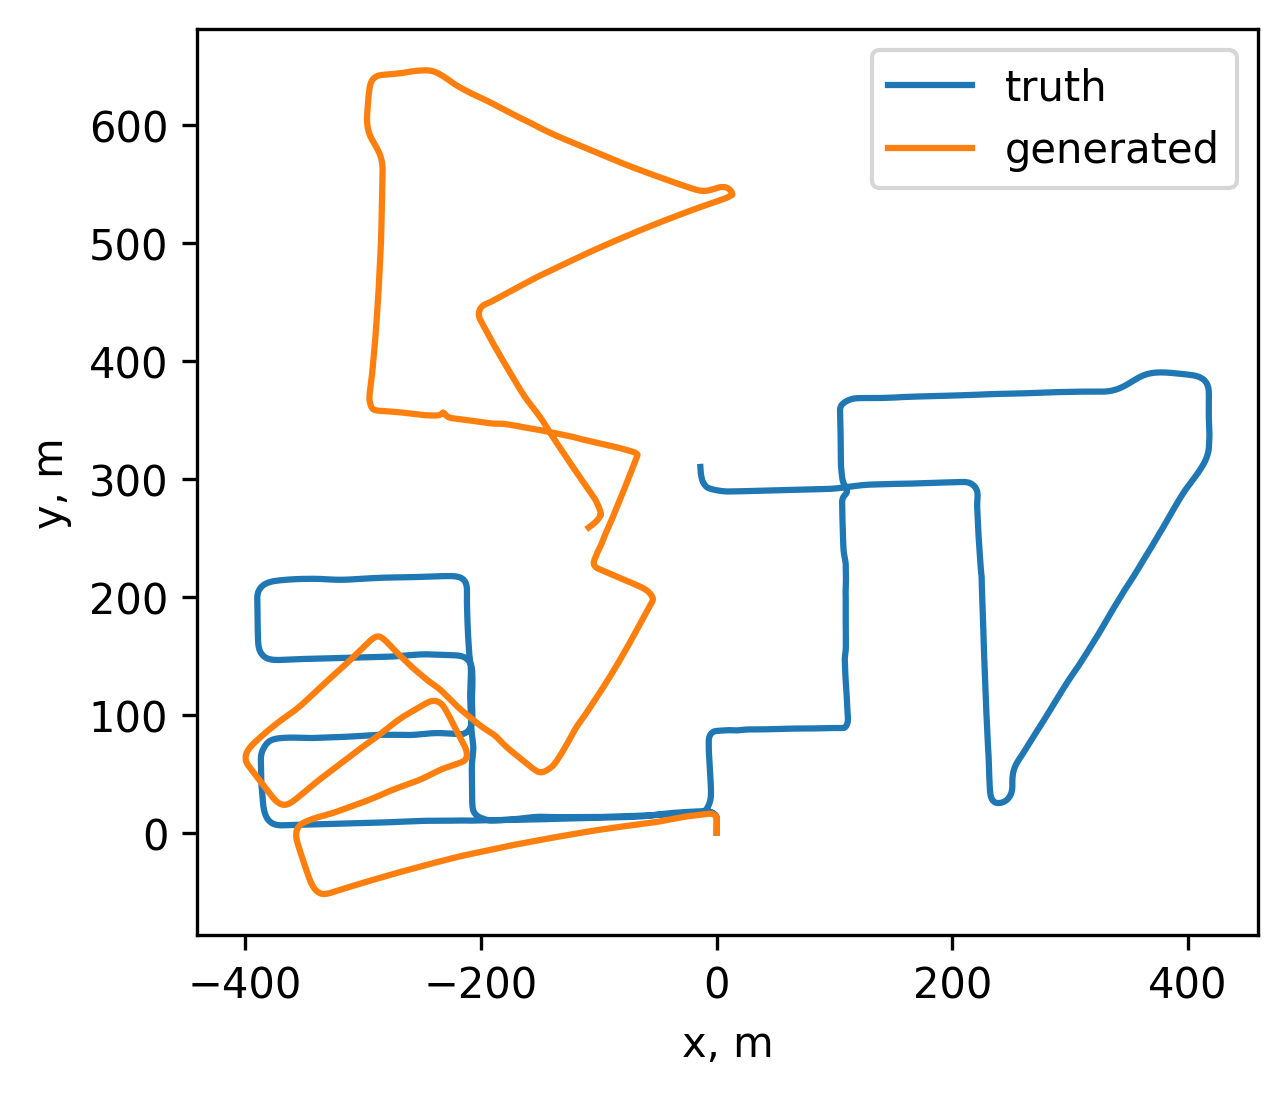

In [ ]:
truth_trajectory = []
trajectory = []
for pose, predicted_pose in zip(dataset.poses, predicted_poses):
    truth_trajectory.append(pose[:3, 3])
    trajectory.append(predicted_pose[:3, 3])
truth_trajectory = np.array(truth_trajectory)
trajectory = np.array(trajectory)
plt.figure(dpi=300)
plt.plot(truth_trajectory[:, 0], truth_trajectory[:, 2], label="truth")
plt.plot(trajectory[:, 0], trajectory[:, 2], label="generated")
plt.gca().set_aspect('equal')
plt.legend()
plt.xlabel("x, m")
plt.ylabel("y, m")

In [ ]:
with open("08.txt", "w") as fd:
    for pose in predicted_poses:
        fd.write(" ".join(list(map(str, (pose[:3, :].reshape(12))))) + "\n")

In [ ]:
!git clone https://github.com/Huangying-Zhan/kitti-odom-eval

fatal: destination path 'kitti-odom-eval' already exists and is not an empty directory.


In [ ]:
!cd kitti-odom-eval && python eval_odom.py --result .. --align 7dof --seqs  8

Evaluate result in ..? [y/n]y
Sequence: 8
Translational error (%):  10.673025554394846
Rotational error (deg/100m):  4.627939167597236
ATE (m):  100.51943430781112
RPE (m):  0.06605336856923225
RPE (deg):  0.08619331604294324
-------------------- For Copying ------------------------------
10.67
4.63
100.52
0.066
0.086
